# Teranet dataset
# Exploratory Spatial Data Analysis (ESDA)
# Alpha-shapes
This notebook describes the process of generating [alpha shapes](https://en.wikipedia.org/wiki/Alpha_shape) from Teranet records.  


## Summary of the previous steps
Teranet records previously were: 
* cleaned and filtered for duplicates
    * `consideration_amt` < $30 were reset to NaN (Not a Number, missing values)
    * records matching on all columns have been removed (83'798 records)
    * records matching on all columns excluding `pin` have been removed (729'182 records)
    * **813'138 duplicate entries** removed in total from original Teranet dataset 
    * 8'226'103 unique records remain after duplicates have been removed
    * see notebook `data_cleaning/Teranet_data_cleaning.ipynb` for details

* filtered to include only records from GTHA 
    * filtering performed via a spatial join
    * `xy` coordinates of Teranet records joined (how='inner', op='within') with DA geometry for GTHA 
    * DA geometry provided by York Municipal Government (accessed via Esri Open Data portal)
    * 6,062,853 records have `xy` coordinates within GTHA boundary
    * see notebook `data_cleaning/Teranet_GTHA_DA_spatial_join.ipynb` for details

## Alpha shapes
From [wikipedia](https://en.wikipedia.org/wiki/Alpha_shape):  
In computational geometry, an alpha shape, or α-shape, is a family of piecewise linear simple curves in the Euclidean plane associated with the shape of a finite set of points. They were first defined by [Edelsbrunner, Kirkpatrick & Seidel (1983)](https://ieeexplore.ieee.org/document/1056714). The alpha-shape associated with a set of points is a generalization of the concept of the convex hull, i.e. every convex hull is an alpha-shape but not every alpha shape is a convex hull.

<img src='img/alpha_shapes.png'>

In this notebook, alpha shapes (polygons) will be generated from Teranet point data using PySal library in Python.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import seaborn as sns
from pysal.lib.cg import alpha_shape_auto
import contextily as ctx
import os
import sys
import time

C:\ProgramData\Anaconda3\envs\gds\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
os.chdir('Documents/repos/geo')
os.listdir()

['.git',
 '.gitattributes',
 '.gitignore',
 '.idea',
 '.ipynb_checkpoints',
 'data',
 'downloads',
 'img',
 'notebooks',
 'presentations',
 'README.md',
 'src',
 '__pycache__']

In [ ]:
sys.path.append('src')

In [4]:
dtypes = {
    'decade': 'int',
    'year': 'int',
    'lro_num': 'category',
    'pin': 'category',
    'postal_code': 'category',
    'street_designation': 'category',
    'street_direction': 'category',
    'municipality': 'category',
    'da_id': 'category',
    'xy': 'category'
}
t = time.time()
teranet_path = 'data/HHSaleHistory_cleaned_v0.9_GTHA_DA_with_cols_v0.9.csv'
df = pd.read_csv(teranet_path,
                 dtype=dtypes,
                 parse_dates=['registration_date'])\
        .set_index('registration_date').sort_index()
elapsed = time.time() - t
print("----- DataFrame with Teranet records loaded"
      "\nin {0:.2f} seconds".format(elapsed) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- DataFrame with Teranet records loaded
in 61.95 seconds
with 4,637,584 rows
and 37 columns
-- Column names:
 Index(['decade', 'year', 'lro_num', 'pin', 'consideration_amt', 'postal_code',
       'unitno', 'street_name', 'street_designation', 'street_direction',
       'municipality', 'street_number', 'x', 'y', 'da_id', 'da_city',
       'da_median_tot_inc', 'xy', 'pin_total_sales', 'xy_total_sales',
       'pin_prev_sales', 'xy_prev_sales', 'pin_price_cum_sum',
       'xy_price_cum_sum', 'pin_price_pct_change', 'xy_price_pct_change',
       'price_da_pct_change', 'pin_years_since_last_sale',
       'xy_years_since_last_sale', 'da_days_since_last_sale',
       'da_years_since_last_sale', 'pin_sale_next_6m', 'pin_sale_next_1y',
       'pin_sale_next_3y', 'xy_sale_next_6m', 'xy_sale_next_1y',
       'xy_sale_next_3y'],
      dtype='object')


In [5]:
def map_alpha(df, start, stop, 
              color_col, date_col, dfd, min_counts,
              action='show', 
              save_path_noctx='img/gen/noctx/',
              save_path_ctx='img/gen/ctx/'):
    """
    make a subset of Teranet records 
    and create alpha shapes from it
    :param df: 
    :param start: 
    :param stop: 
    :param color_col: 
    :param date_col: 
    :param dfd: 
    :param min_counts: 
    :param action: 
    :param save_path: 
    :return: 
    """
    def plot_map(cont, act):
        """
        internal function to plot a map
        :param cont: 
        :param act: 
        :return: 
        """
        f, ax = plt.subplots(1, figsize=(12, 12))
        alpha.reset_index()\
            .plot(column=color_col, legend=True, 
              legend_kwds={'loc': 'lower right'}, 
              ax=ax, alpha=0.5)
        for idx, mun in alpha.iterrows():
            mun_centroid = mun['geometry'].centroid
            ax.text(mun_centroid.x, mun_centroid.y, idx
                    + "\n{0:,} records".format(mun_counts[idx]))
        ax.set_title("Alpha shapes of each GTHA municipality\n"
                     "based on Teranet records from {0} to {1}"
                     .format(min_date,
                             max_date), fontsize=20)
        ax.set_xlim(-8940996.776086302, -8723064.623629777)
        ax.set_ylim(5313237.739935117, 5555494.494204169)
        if cont:
            ctx.add_basemap(ax=ax, url=ctx.sources.ST_TONER_HYBRID, 
                            alpha=0.5)
            if act == 'show':
                plt.show()
            elif act == 'save':
                plt.savefig(save_path_ctx + 
                            str(min_date)[:10]
                            + '_' + 
                            str(max_date)[:10])
        else:
            if act == 'show':
                plt.show()
            elif act == 'save':
                plt.savefig(save_path_noctx + 
                            str(min_date)[:10] 
                            + '_' + 
                            str(max_date)[:10])
        
    s = df.loc[start:stop].reset_index()
    min_date = s[date_col].min()
    max_date = s[date_col].max()
    print("{0} points in the subset from {1} to {2}."
          .format(len(s), 
                  min_date,
                  max_date))
    mun_counts = s.groupby(color_col)['x'].count()
    dfd[int(start[:4])] = mun_counts
    mun_list = \
        list(mun_counts[mun_counts > min_counts].index)
    mask = s[color_col].isin(mun_list)
    s = s[mask]
    alpha = s.groupby(color_col)[['x', 'y']]\
        .apply(lambda tab: alpha_shape_auto(tab.values))
    alpha = gpd.GeoDataFrame({'geometry': alpha}, crs='+init=epsg:4326') 
    alpha = alpha.to_crs(epsg=3857)
    plot_map(cont=False, act=action)
    plot_map(cont=True, act=action)

In [ ]:
start_year = 1930
end_year = 2017
color_col='da_city'
date_col = 'registration_date'
dfd = dict()
for i in range(start_year, end_year + 1):
    start = str(i) + '-01-01'
    stop = str(int(start[:4]) + 1) + '-01-01'
    try:
        map_alpha(df, start, stop, 
                  color_col, date_col, dfd, 8,
                  action='save')
    except:
        print("QhullError!")

208 points in the subset from 1930-01-04 00:00:00 to 1930-12-31 00:00:00.
172 points in the subset from 1931-01-02 00:00:00 to 1931-12-29 00:00:00.
195 points in the subset from 1932-01-06 00:00:00 to 1932-12-30 00:00:00.
72 points in the subset from 1933-01-04 00:00:00 to 1933-12-02 00:00:00.
62 points in the subset from 1934-01-04 00:00:00 to 1934-12-26 00:00:00.
108 points in the subset from 1935-01-03 00:00:00 to 1935-12-18 00:00:00.
77 points in the subset from 1936-01-10 00:00:00 to 1936-12-28 00:00:00.
113 points in the subset from 1937-01-13 00:00:00 to 1937-12-31 00:00:00.
89 points in the subset from 1938-01-04 00:00:00 to 1938-12-31 00:00:00.
134 points in the subset from 1939-01-04 00:00:00 to 1939-12-29 00:00:00.
142 points in the subset from 1940-01-04 00:00:00 to 1940-12-31 00:00:00.
255 points in the subset from 1941-01-06 00:00:00 to 1941-12-29 00:00:00.
159 points in the subset from 1942-01-05 00:00:00 to 1942-12-31 00:00:00.
173 points in the subset from 1943-01-04 0

C:\ProgramData\Anaconda3\envs\gds\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [7]:
colors = sns.color_palette('Set1', n_colors=25, desat=.5)

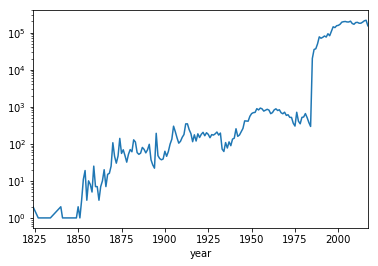

In [17]:
df.groupby('year')['x'].count().plot()
plt.yscale('log')